# Introduction
* This notebook contains an implementation of matrix factorization uning Keras.
* Matrix factorization is an algorithm used for recommendation, for example to predict a user's rating of a movie.  This algorithm uses embedding to create two matrices, of the users and movies, such that their dot product gives the desired rating.
* The data I used for this project is the MovieLens 100k, from GroupLens: https://grouplens.org/datasets/movielens/100k/
* In the full data set there are 100000 ratings by 943 users on 1682 movies, where each user has rated at least 20 movies.
* The data sets ratings_train.csv and ratings_test.csv split the full data into a training set and a test set with exactly 10 ratings per user in the test set.
* Using simple collborative filtering, I got a mean squared error score on the test data set of 1.04.
* Using matrix factorization, I got a mean squared error score on the test data set of 1.34.

### The notebook is divided into the following parts:
* [Part 1: Notebook preparation](#part_1)
* [Part 2: Data exploration](#part_2)
* [Part 3: Data preparation](#part_3)
* [Part 4: Matrix factorization](#part_4)
* [Part 5: Predict the test data and evaluate the model with MSE](#part_5)

<a id="part_1"></a>
# Part 1: Notebook preparation

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Deep learning
import keras
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Embedding, Activation, Dot, BatchNormalization
from keras.layers.merge import dot
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [2]:
df_train = pd.read_csv('ratings_train.csv', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
df_test = pd.read_csv('ratings_test.csv', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

<a id="part_2"></a>
# Part 2: Data exploration

In [3]:
display(df_train.head(5))
print(f"Shape: {df_train.shape}")

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


Shape: (90570, 4)


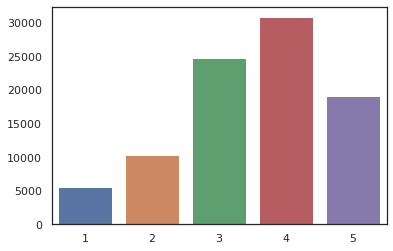

In [4]:
# Rating histogram
sns.barplot(df_train['rating'].value_counts().index, df_train['rating'].value_counts().values)

In [5]:
mostCommonRating = df_train['rating'].value_counts().index[0]

In [6]:
print(f"Unique users in training set: {len(df_train['userId'].unique())}")
print(f"Unique movies in training set: {len(df_train['movieId'].unique())}")
print(f"Total unique movies in training and test set: {len(set(df_train['movieId'].unique()) | set(df_test['movieId'].unique()))}")

Unique users in training set: 943
Unique movies in training set: 1680
Total unique movies in training and test set: 1682


Min ratings per user in training set: 10
Max ratings per user in training set: 727


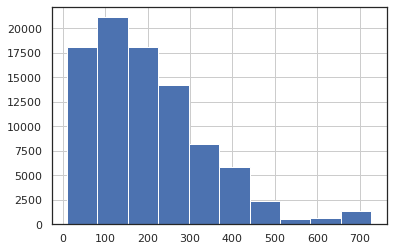

In [7]:
df_train['countPerUser'] = df_train.groupby('userId')['userId'].transform('count')

print(f"Min ratings per user in training set: {df_train['countPerUser'].min()}")
print(f"Max ratings per user in training set: {df_train['countPerUser'].max()}")
df_train['countPerUser'].hist()

In [8]:
display(df_test.head(5))
print(f"Shape: {df_test.shape}")

,userId,movieId,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


Shape: (9430, 4)


<a id="part_3"></a>
# Part 3: Data preparation

In [9]:
df_train.userId = df_train.userId.astype('category').cat.codes.values
df_train.movieId = df_train.movieId.astype('category').cat.codes.values
df_test.userId = df_test.userId.astype('category').cat.codes.values
df_test.movieId = df_test.movieId.astype('category').cat.codes.values

<a id="part_4"></a>
# Part 4: Matrix factorization

In [10]:
embed_size = 10
n_movies = len(df_train['movieId'].unique())
n_users = len(df_train['userId'].unique())

In [11]:
user_input = Input(shape=(1,), name='user_input',dtype='int64')
user_embedding = Embedding(n_users, embed_size, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
user_vec = Dropout(0.4)(user_vec)

movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, embed_size, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
movie_vec = Dropout(0.4)(movie_vec)

dot_product = dot([user_vec , movie_vec], name='dot_product', axes=1)

prediction = Dense(1, activation='relu')(dot_product)
model = Model(inputs = [user_input, movie_input], outputs = prediction)

model.compile(optimizer='adam', loss='mse')

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        9430        user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 10)        16800       movie_input[0][0]                
____________________________________________________________________________________________

In [13]:
batch_size=128
epochs=20

History = model.fit([df_train.userId, df_train.movieId], df_train.rating, batch_size=batch_size,
                     epochs=epochs, validation_data=([df_test.userId, df_test.movieId], df_test.rating), verbose = 1)


Instructions for updating:
Use tf.cast instead.
Train on 90570 samples, validate on 9430 samples
Epoch 1/20
90570/90570 [==============================] - 1s 14us/step - loss: 11.0542 - val_loss: 8.4987
Epoch 2/20
90570/90570 [==============================] - 1s 11us/step - loss: 3.7484 - val_loss: 3.4539
Epoch 3/20
90570/90570 [==============================] - 1s 11us/step - loss: 2.1539 - val_loss: 2.3623
Epoch 4/20
90570/90570 [==============================] - 1s 11us/step - loss: 1.7951 - val_loss: 1.8759
Epoch 5/20
90570/90570 [==============================] - 1s 11us/step - loss: 1.5648 - val_loss: 1.6024
Epoch 6/20
90570/90570 [==============================] - 1s 11us/step - loss: 1.4078 - val_loss: 1.4493
Epoch 7/20
90570/90570 [==============================] - 1s 11us/step - loss: 1.2690 - val_loss: 1.3459
Epoch 8/20
90570/90570 [==============================] - 1s 13us/step - loss: 1.1773 - val_loss: 1.2840
Epoch 9/20
90570/90570 [==============================] - 1s 1

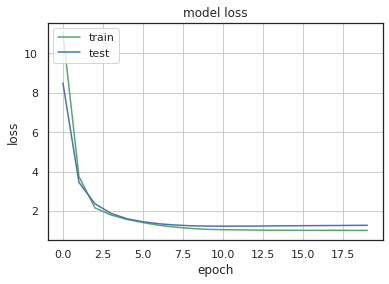

In [14]:
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

<a id="part_5"></a>
# Part 5: Predict the test data and evaluate the model with MSE

In [15]:
y_hat_train = np.round(model.predict([df_train.userId, df_train.movieId]),0)
y_true_train = df_train.rating

y_hat_test = np.round(model.predict([df_test.userId, df_test.movieId]),0)
y_true_test = df_test.rating

mse_train = mean_squared_error(y_true_train, y_hat_train)
mse_test = mean_squared_error(y_true_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

Train MSE: 0.9905487468256597
Test MSE: 1.3419936373276777
